In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import special
from scipy import signal
import xarray.ufuncs as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns



In [3]:
data_dir = '/data/deluge/reanalysis/REANALYSIS/ERA5/2D/daily/precip/'

In [5]:
ds = xr.open_mfdataset(data_dir+'*.nc',parallel=True, chunks={'latitude': 25, 'longitude': 25, 'time': -1})

In [7]:
# lon=255, # lat=48.0

<xarray.Dataset>
Dimensions:    (time: 25582)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-02-01T11:00:00
    longitude  float32 255.0
    latitude   float32 48.0
Data variables:
    precip     (time) float32 1.129 1.503 0.183 0.004741 ... 3.111 0.04009 0.016

In [16]:
data = ds.sel(latitude=48.0, longitude=255.0)['precip']

In [7]:
ds

<xarray.Dataset>
Dimensions:    (time: 25658, bnds: 2, longitude: 720, latitude: 361)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-03-31T11:00:00
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(31, 25, 25), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:30:53 2021: cdo -b F32 daysum precip.195001.n...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [8]:
OD_data = xr.open_dataset('OnsetDemise_ERA5.nc')

In [17]:
OD_ts = OD_data.sel(latitude=36.0, longitude=264.0)

In [18]:
onset_interval = np.empty(4)
demise_interval = np.empty(4)

def OD_ci(data):
    
    m = np.nanmean(data.values)
    s = np.nanstd(data.values)
    c = len(data.values)
    upper = (m + 1.96*s/np.sqrt(c))
    lower = (m - 1.96*s/np.sqrt(c))
    return np.array([m,s,upper,lower])

onset_interval = OD_ci(OD_ts['onset_doy'])
demise_interval = OD_ci(OD_ts['demise_doy'])


In [63]:
onset_interval

array([113.88571429,  27.56060483, 120.34219407, 107.4292345 ])

In [64]:
demise_interval

array([238.63768116,  38.6222775 , 247.68552156, 229.58984076])

In [19]:
#data is in meters
data = data * 1000.0

In [20]:
### Creating the anomaly data
anomaly = data - data.mean()

In [21]:
array_jday = anomaly.time.dt.dayofyear
anomaly = anomaly.assign_coords(jday=("time",array_jday.data))

In [22]:
pd_anomaly = anomaly.rolling(time=60,center=True).sum().to_dataframe()

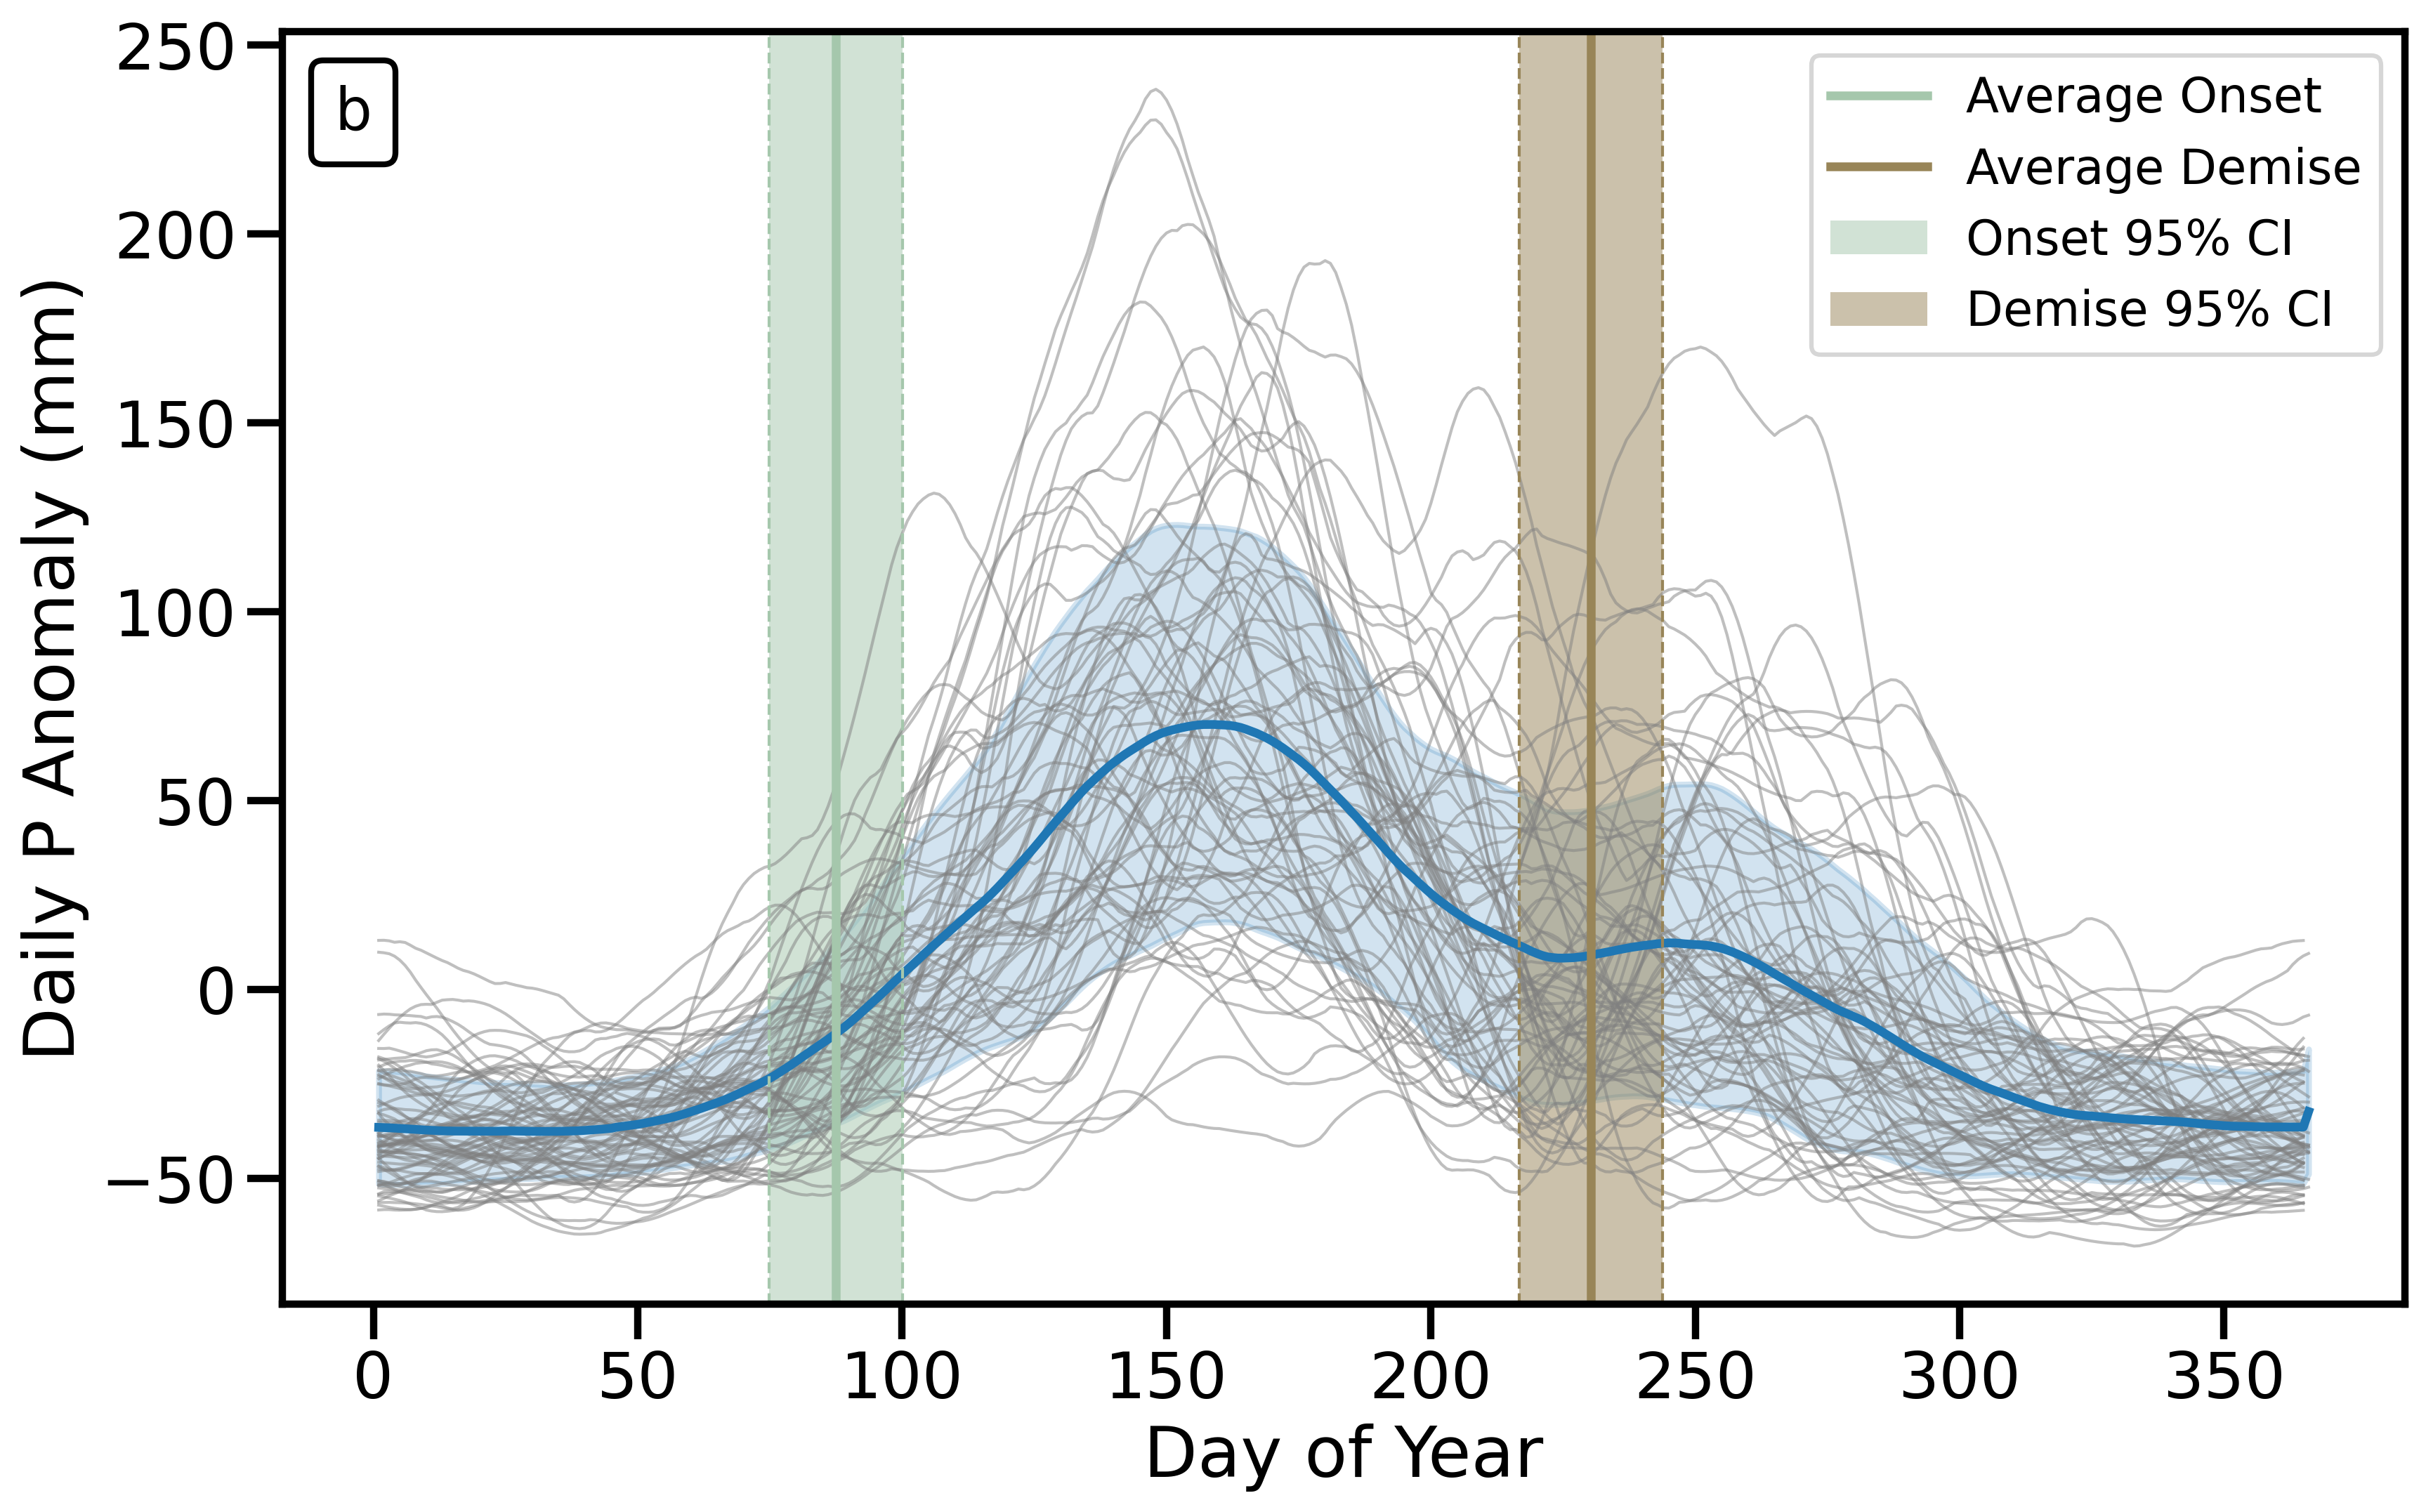

In [23]:
plt.figure(figsize = (13, 8), dpi = 300)
sns.set_context("poster")

pd_anomaly['time'] = pd_anomaly.index
pd_anomaly['dayofyear'] = pd_anomaly['time'].dt.dayofyear
pd_anomaly['year'] = pd_anomaly['time'].dt.year
pd_anomaly['smooth_tp'] = signal.savgol_filter(pd_anomaly['precip'],31,3)

ax = sns.lineplot(data=pd_anomaly, x='dayofyear',y='smooth_tp',estimator=None, lw=1, alpha=.5, units='year',color='gray')
sns.lineplot(data=pd_anomaly, x='dayofyear',y='smooth_tp',palette='blue', ci='sd', err_style='band', ax=ax)

ax.axvline(onset_interval[0], color='#a5c7ac', linestyle='-', lw=3, label='Average Onset')

ax.axvline(demise_interval[0], color='#988558', linestyle='-', lw=3, label='Average Demise')
ax.axvspan(onset_interval[2],onset_interval[3],facecolor='#a5c7ac', alpha=0.5, linestyle='--', label='Onset 95% CI')
ax.axvline(onset_interval[2], color='#a5c7ac', linestyle='--', lw=1)
ax.axvline(onset_interval[3], color='#a5c7ac', linestyle='--', lw=1)

ax.axvspan(demise_interval[2],demise_interval[3],facecolor='#988558', alpha=0.5, linestyle='--',label='Demise 95% CI')
ax.axvline(demise_interval[2], color='#988558', linestyle='--', lw=1)
ax.axvline(demise_interval[3], color='#988558', linestyle='--', lw=1)
ax.set_ylabel('Daily P Anomaly (mm)')
ax.set_xlabel('Day of Year')
at = AnchoredText("b",
                      loc='upper left', prop=dict(size=20), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

sns.set_context("talk")
ax.legend()


#ax.set_title('Southeast U.S.')


In [82]:
wetseason_count = xr.open_dataarray('average_wetseasons_na.nc').sel(latitude=slice(60,20), longitude=slice((360.0-125),(360.0-65.0)))

In [108]:
wetseason_count

<xarray.DataArray 'precip' (latitude: 81, longitude: 121)>
array([[1.042254, 1.042254, 1.070423, ..., 1.070423, 1.070423, 1.042254],
       [1.098592, 1.126761, 1.126761, ..., 1.042254, 1.014085, 1.028169],
       [1.028169, 1.042254, 1.056338, ..., 1.042254, 1.042254, 1.014085],
       ...,
       [1.239437, 1.323944, 1.253521, ..., 1.323944, 1.309859, 1.295775],
       [1.28169 , 1.28169 , 1.309859, ..., 1.295775, 1.239437, 1.239437],
       [1.267606, 1.253521, 1.211268, ..., 1.239437, 1.211268, 1.225352]])
Coordinates:
  * longitude  (longitude) float32 235.0 235.5 236.0 236.5 ... 294.0 294.5 295.0
  * latitude   (latitude) float32 60.0 59.5 59.0 58.5 ... 21.5 21.0 20.5 20.0

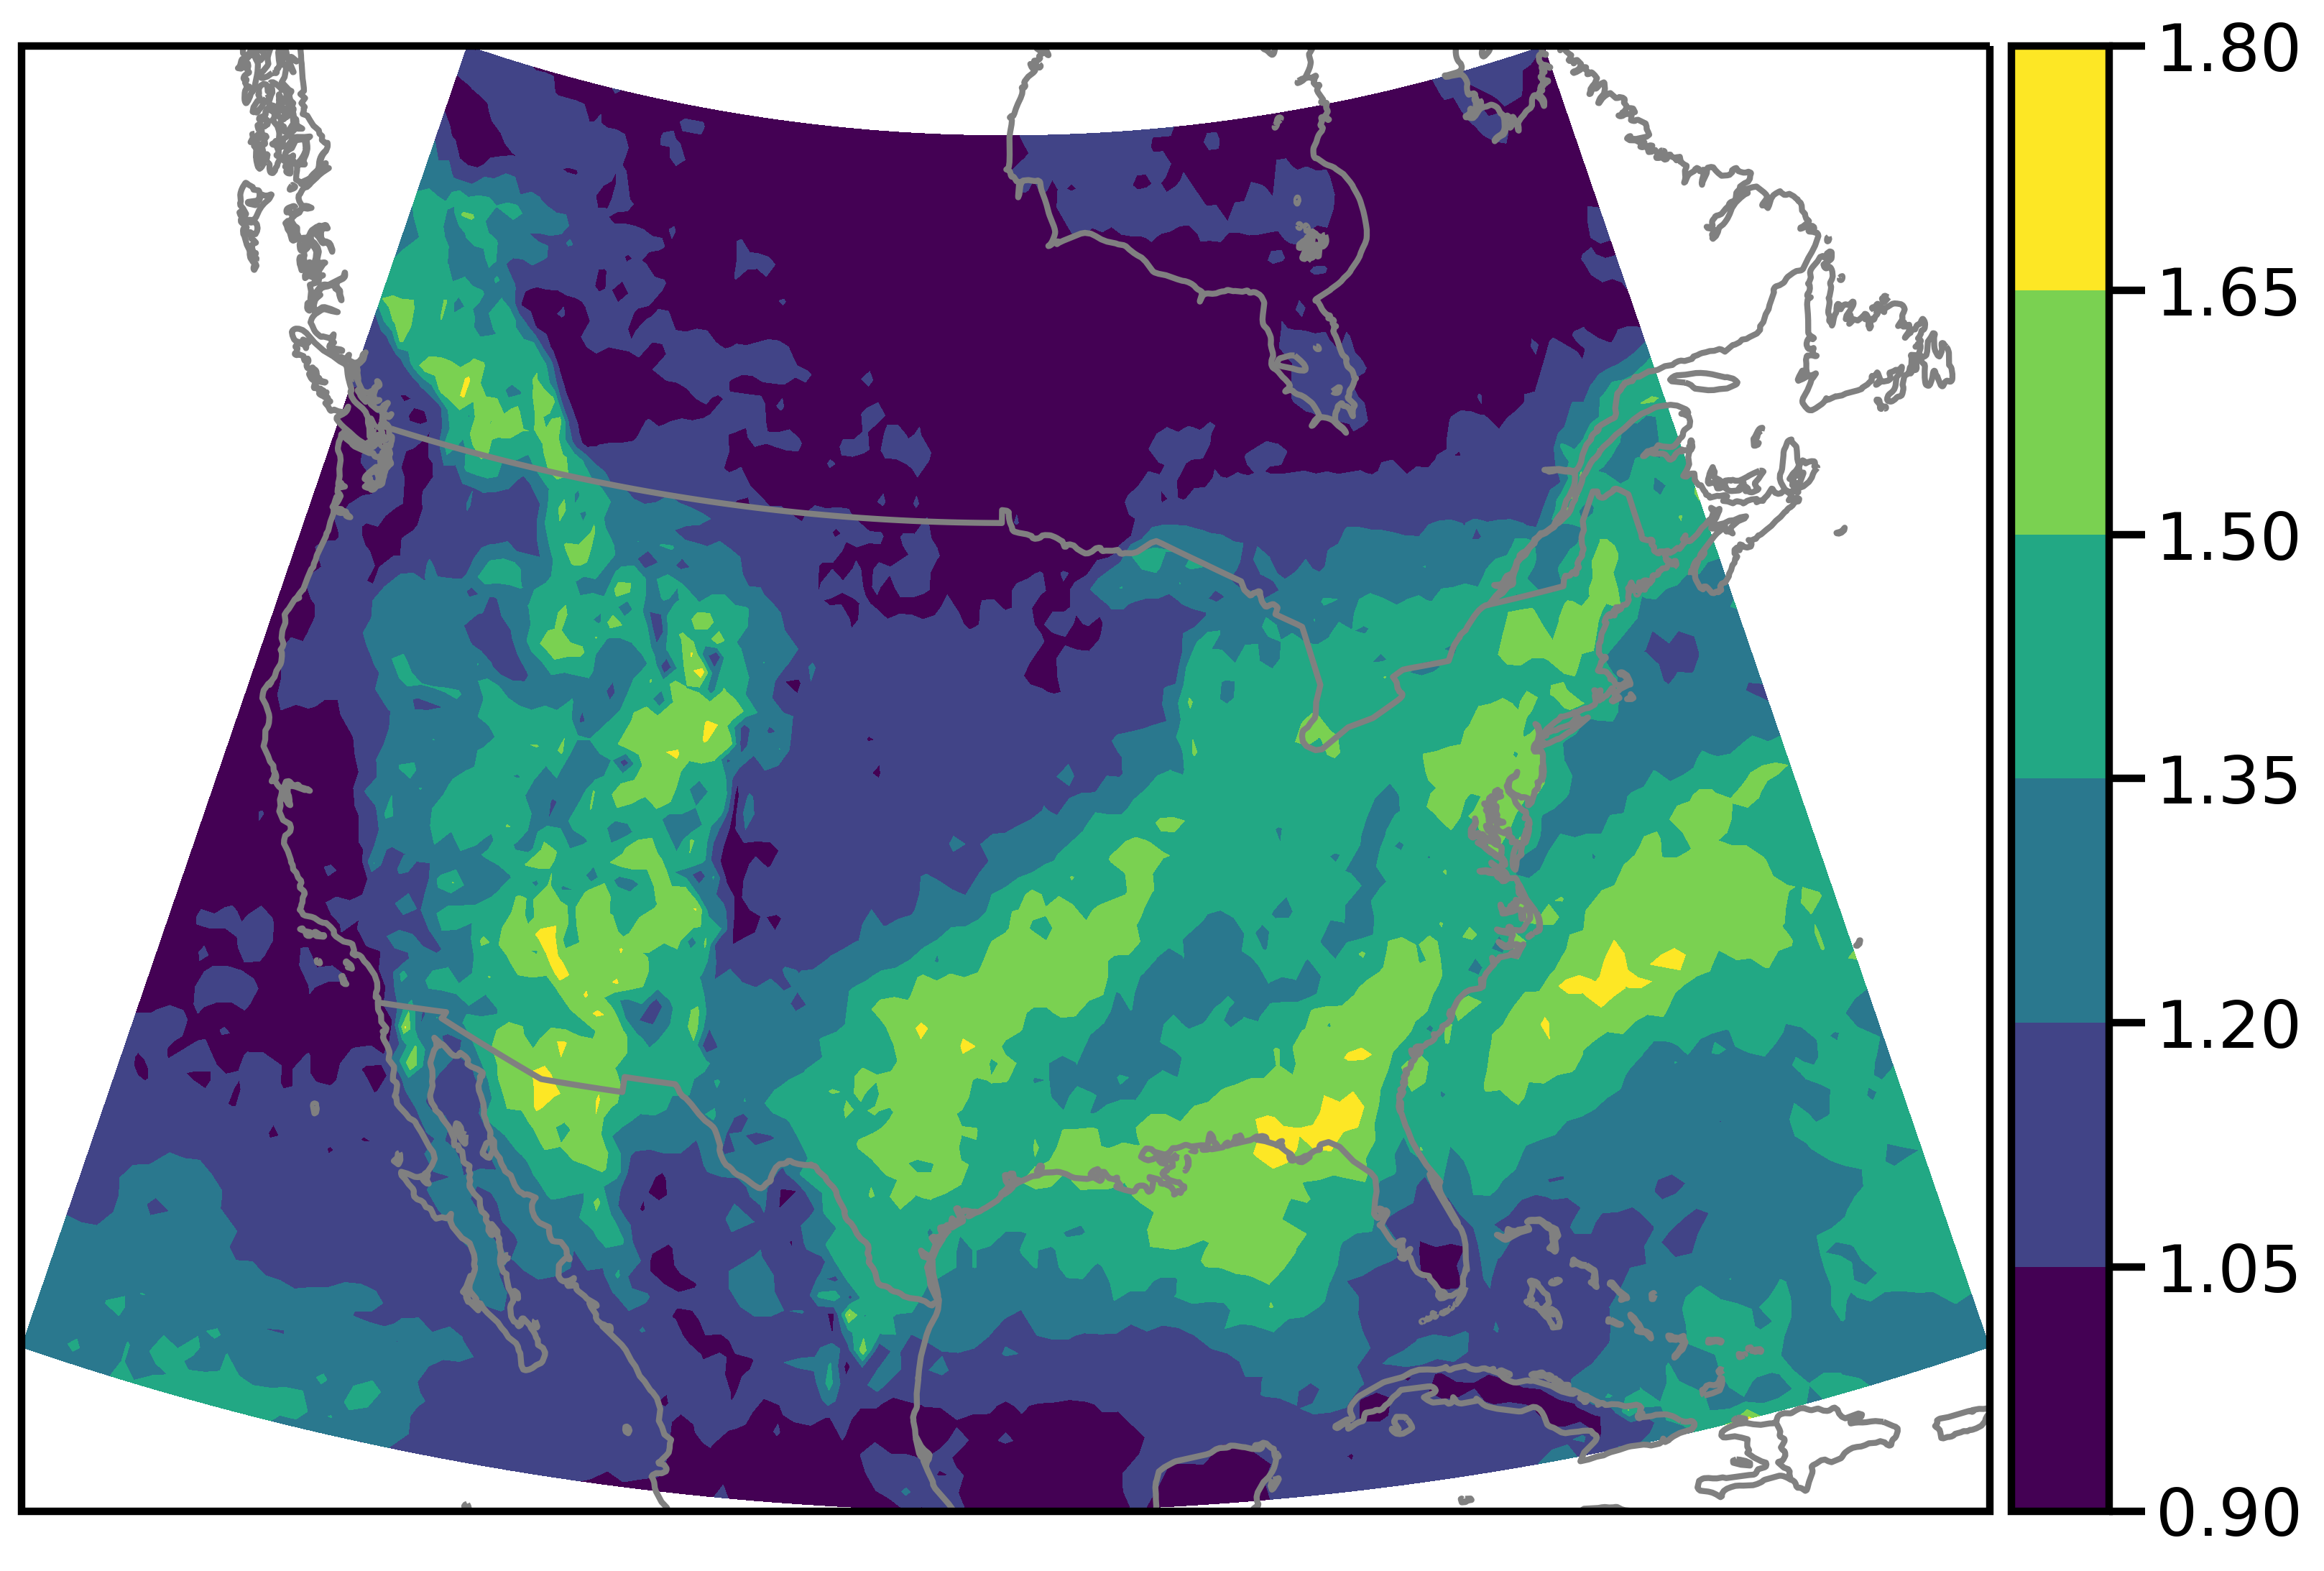

In [97]:
plt.figure(figsize = (27, 9), dpi = 300)
sns.set_context('poster')
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r


ax1 = plt.subplot(1, 1,1, projection=map_proj)
p = wetseason_count.plot.contourf(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False)

ax1.set_aspect('equal')
### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='grey')
#ax1.add_feature(cfeature.STATES, color='grey')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
#ax1.set_title('Standard Deviation of Pentads')
#at = AnchoredText("a",
#                      loc='upper left', prop=dict(size=20), frameon=True,)
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)

In [42]:
onset_interval[3]

107.42923450180727

In [14]:
test = xr.open_dataset('wetseason.onset.era5.nc')

In [15]:
test['onset_date'].sel(latitude=33,longitude=273).sel(year=2009)

<xarray.DataArray 'onset_date' ()>
array(51.)
Coordinates:
    longitude  float32 273.0
    latitude   float32 33.0
    year       int64 2009

In [27]:
test2 = xr.open_dataset('wetseason.demise.era5.nc')


In [28]:
test2['demise_date'].sel(latitude=33,longitude=273).sel(year=2009)

<xarray.DataArray 'demise_date' ()>
array(48.)
Coordinates:
    longitude  float32 273.0
    latitude   float32 33.0
    year       int64 2009